In [1]:
import pandas as pd 
import numpy as np 

train = pd.read_csv('../ML-DL Datasets/train.csv')
train.head(3)

,user_id,industry,location,moved_after_2019,ITU,YTU,anadolu_üniversitesi,diğer_school,ege_üniversitesi,hacettepe_üniversitesi,...,Software Development,Software Engineering,Spring Framework,Teamwork,Visual Studio,Web Development,XML,jQuery,other,skill_count
0,1301,Information Technology,istanbul,1,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,23.0
1,6950,Information Technology,istanbul,0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,49.0
2,4880,Others,diğer,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,21.0


In [2]:
spec_cols = ['school_count', 'experience_month', 'exp_comp_count', 'language_count', 'skill_count', 'industry', 'location']
train[spec_cols].head()

,school_count,experience_month,exp_comp_count,language_count,skill_count,industry,location
0,2.0,92.0,4.0,2.0,23.0,Information Technology,istanbul
1,1.0,117.0,6.0,3.0,49.0,Information Technology,istanbul
2,2.0,108.0,4.0,0.0,21.0,Others,diğer
3,3.0,160.0,4.0,1.0,30.0,Information Technology,istanbul
4,2.0,160.0,3.0,2.0,48.0,Financial Services,istanbul


In [3]:
# scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [4]:
train[['school_count', 'experience_month', 'exp_comp_count', 'language_count', 'skill_count']] = sc.fit_transform(train[['school_count', 'experience_month', 'exp_comp_count', 'language_count', 'skill_count']])
train[['school_count', 'experience_month', 'exp_comp_count', 'language_count', 'skill_count']].head()

,school_count,experience_month,exp_comp_count,language_count,skill_count
0,-0.132132,-0.147686,0.487529,0.696960,0.140200
1,-1.002056,0.208104,1.384526,1.516626,2.018894
2,-0.132132,0.080019,0.487529,-0.942370,-0.004315
3,0.737792,0.820063,0.487529,-0.122705,0.646002
4,-0.132132,0.820063,0.039031,0.696960,1.946637


In [5]:
# label encoder
from sklearn.preprocessing import LabelEncoder
industry_le = LabelEncoder()
location_le = LabelEncoder()

In [6]:
train['industry'] = industry_le.fit_transform(train['industry'])
train['location'] = location_le.fit_transform(train['location'])
train[['industry', 'location']].head()

,industry,location
0,11,8
1,11,8
2,16,5
3,11,8
4,8,8


In [7]:
train[spec_cols].head()

,school_count,experience_month,exp_comp_count,language_count,skill_count,industry,location
0,-0.132132,-0.147686,0.487529,0.696960,0.140200,11,8
1,-1.002056,0.208104,1.384526,1.516626,2.018894,11,8
2,-0.132132,0.080019,0.487529,-0.942370,-0.004315,16,5
3,0.737792,0.820063,0.487529,-0.122705,0.646002,11,8
4,-0.132132,0.820063,0.039031,0.696960,1.946637,8,8


In [8]:
train = train.drop(['user_id'], axis=1)
X = train.drop(['moved_after_2019'], axis=1)
y = train[['moved_after_2019']]

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)

In [33]:
class_weight = {0:2, 1:3}

In [47]:
import xgboost as xgb

xgb_train = xgb.DMatrix(data=X_train, label=y_train)
xgb_val = xgb.DMatrix(data=X_val, label=y_val)
xgb_test = xgb.DMatrix(data=X_test, label=y_test)

params = {'max_depth': 3, 'eta': 0.1, 'subsample': 0.5, 'lambda': 1, 'alpha': 0}

xgb_model = xgb.train(params, xgb_train, num_boost_round=100, evals=[(xgb_val, "Validation")], verbose_eval=False)

In [30]:
xgb_predictions = xgb_model.predict(xgb_test)

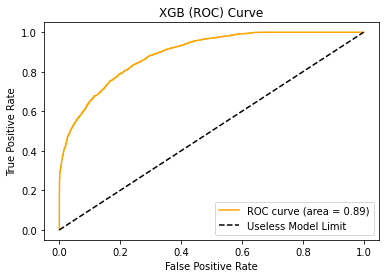

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt 

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, xgb_predictions)
auc = roc_auc_score(y_test, xgb_predictions)

plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:0.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Useless Model Limit')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB (ROC) Curve')
plt.legend(loc="lower right")

plt.savefig('../Images/XGB_2_ROC.png')
plt.show()

In [41]:
class_report = pd.DataFrame(classification_report(y_test, np.round(xgb_predictions), output_dict=True))
class_report

,0,1,accuracy,macro avg,weighted avg
precision,0.814645,0.774972,0.801132,0.794809,0.799324
recall,0.875123,0.683532,0.801132,0.779327,0.801132
f1-score,0.843802,0.726386,0.801132,0.785094,0.798456
support,8136.000000,5119.000000,0.801132,13255.000000,13255.000000


In [51]:
from sklearn.model_selection import GridSearchCV

xgb_model = XGBClassifier()

params = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001],
    "n_estimators": [50, 100, 200]
}

grid_search = GridSearchCV(
    xgb_model,
    param_grid=params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_result = grid_search.fit(X_train, y_train)

In [52]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.828455 using {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [55]:
xgb_model = xgb.XGBClassifier(**grid_result.best_params_)
xgb_model.fit(X_train, np.ravel(y_train))

y_pred = xgb_model.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.840836,0.814637,0.831762,0.827736,0.830718
recall,0.895403,0.730611,0.831762,0.813007,0.831762
f1-score,0.867262,0.770340,0.831762,0.818801,0.829831
support,8136.000000,5119.000000,0.831762,13255.000000,13255.000000


In [57]:
#save model
xgb_model.save_model('../Boosts/XGBoost_Model.json')

# load model
# import xgboost as xgb
# model2 = xgb.XGBClassifier()
# model2.load_model("model_sklearn.json")

<hr>